In [1]:
# Install necessary libraries
!pip install datasets

  Using cached datasets-3.0.1-py3-none-any.whl.metadata (20 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached pyarrow-17.0.0-cp311-cp311-win_amd64.whl.metadata (3.4 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.17-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.25.2-py3-none-any.whl.metadata (13 kB)
  Using cached aiohappyeyeballs-2.4.3-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
  Using cached multiprocess-0.70.16-py

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.14.0 requires jedi>=0.16, which is not installed.
mediapipe 0.10.8 requires matplotlib, which is not installed.
mediapipe 0.10.8 requires sounddevice>=0.4.4, which is not installed.
mediapipe 0.10.8 requires protobuf<4,>=3.11, but you have protobuf 4.25.5 which is incompatible.


In [3]:
# Import required libraries
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [20]:
tf.__version__

'2.10.0'

In [4]:
# Load the dataset
emotions = load_dataset('SetFit/emotion')

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 27295.56 examples/s]


In [7]:
# Define the data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [13]:
# Prepare TensorFlow datasets
batch_size = 8

# Function to convert dataset to tf.data.Dataset
def convert_to_tf_dataset(split):
    return emotions_encoded[split].to_tf_dataset(
        columns=['input_ids', 'attention_mask', 'token_type_ids'],
        label_cols=['label'],
        shuffle=(split == 'train'),
        batch_size=batch_size,
        collate_fn=data_collator
    )
train_dataset = convert_to_tf_dataset('train')
validation_dataset = convert_to_tf_dataset('validation')
test_dataset = convert_to_tf_dataset('test')

In [10]:
# Load the pre-trained BERT model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Train the model
epochs = 3
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/3
2000/2000 [==============================] - 2884s 1s/step - loss: 0.3693 - accuracy: 0.8727 - val_loss: 0.1590 - val_accuracy: 0.9270
Epoch 2/3
1028/2000 [==============>...............] - ETA: 24:00 - loss: 0.1556 - accuracy: 0.9335

In [35]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'\nTest Accuracy: {test_accuracy:.4f}')

63/63 [==============================] - 10s 159ms/step - loss: 0.1722 - accuracy: 0.9220

Test Accuracy: 0.9220


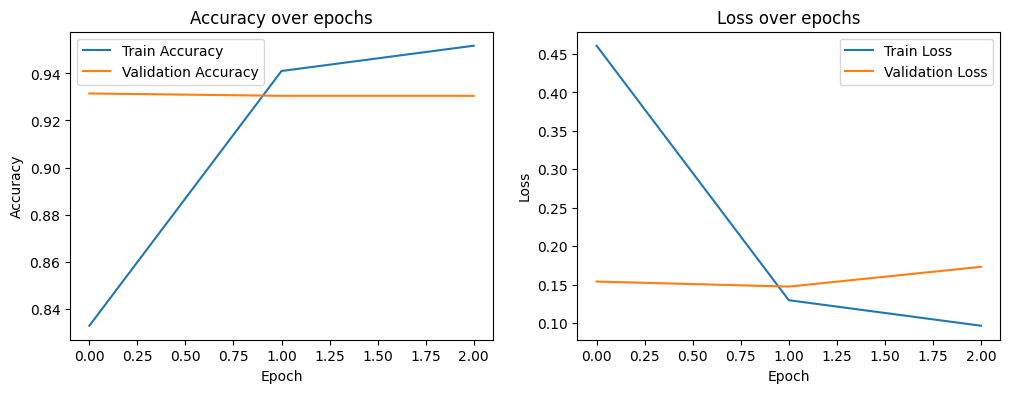

In [36]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

In [37]:
# Define emotion labels
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

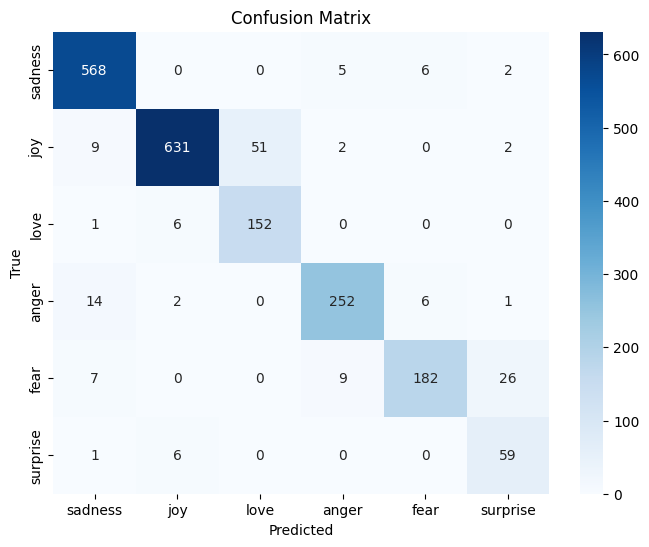

              precision    recall  f1-score   support

     sadness       0.95      0.98      0.96       581
         joy       0.98      0.91      0.94       695
        love       0.75      0.96      0.84       159
       anger       0.94      0.92      0.93       275
        fear       0.94      0.81      0.87       224
    surprise       0.66      0.89      0.76        66

    accuracy                           0.92      2000
   macro avg       0.87      0.91      0.88      2000
weighted avg       0.93      0.92      0.92      2000



In [38]:
# Evaluate model with confusion matrix and classification report
def evaluate_model(model, test_dataset, label_names):
    true_labels = []
    pred_labels = []

    for batch in test_dataset:
        inputs, labels = batch
        outputs = model(inputs)
        logits = outputs.logits
        predictions = tf.argmax(logits, axis=1)
        true_labels.extend(labels.numpy())
        pred_labels.extend(predictions.numpy())

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(true_labels, pred_labels, target_names=label_names))

evaluate_model(model, test_dataset, emotion_labels)

In [39]:
# Save the fine-tuned model
model.save_pretrained('bert_emotion_classifier')

In [40]:
# Function to predict emotion from text
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    return emotion_labels[predicted_class]

In [47]:
# Example usage
text_input = "What a wonderful surprise!"
predicted_emotion = predict_emotion(text_input)
print(f"Input Text: {text_input}\nPredicted Emotion: {predicted_emotion}")

Input Text: What a wonderful surprise!
Predicted Emotion: joy


In [56]:
# Save the model and tokenizer using Hugging Face methods
model.save_pretrained('emotion_model')
tokenizer.save_pretrained('emotion_model')

('emotion_model/tokenizer_config.json',
 'emotion_model/special_tokens_map.json',
 'emotion_model/vocab.txt',
 'emotion_model/added_tokens.json',
 'emotion_model/tokenizer.json')

In [57]:
# Load the model and tokenizer
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

loaded_model = TFAutoModelForSequenceClassification.from_pretrained('emotion_model')
loaded_tokenizer = AutoTokenizer.from_pretrained('emotion_model')

Some layers from the model checkpoint at emotion_model were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at emotion_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [58]:
# Function to predict emotion from text using the loaded model
def predict_emotion(text):
    inputs = loaded_tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = loaded_model(inputs)
    logits = outputs.logits  # Access logits directly
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    return emotion_labels[predicted_class]

# Example sentences
sentences = [
    "I am feeling very happy today!",
    "This is the worst day ever.",
    "I love spending time with you.",
    "I'm so angry right now.",
    "I'm scared of the dark.",
    "What a pleasant surprise!",
    "I feel so sad and lonely.",
    "Your kindness warms my heart.",
    "I can't believe how shocked I am!",
    "This makes me anxious."
]


In [59]:
# Predict emotions for the example sentences
for sentence in sentences:
    emotion = predict_emotion(sentence)
    print(f"Text: {sentence}\nPredicted Emotion: {emotion}\n")

Text: I am feeling very happy today!
Predicted Emotion: joy

Text: This is the worst day ever.
Predicted Emotion: sadness

Text: I love spending time with you.
Predicted Emotion: love

Text: I'm so angry right now.
Predicted Emotion: anger

Text: I'm scared of the dark.
Predicted Emotion: fear

Text: What a pleasant surprise!
Predicted Emotion: joy

Text: I feel so sad and lonely.
Predicted Emotion: sadness

Text: Your kindness warms my heart.
Predicted Emotion: love

Text: I can't believe how shocked I am!
Predicted Emotion: surprise

Text: This makes me anxious.
Predicted Emotion: fear

